# Владимир Смолев
## Практика в WebGame
## Предсказание конверта в плательщика по первому дню игры

Задание:
Имея данные за первый день/два игры, необходимо предсказать вероятность того, что игрок станет плательщиком. Бонус: предсказать тип плательщика (после их стандартной классификации на китов, дельфинов, пескарей и пр.)


Импортирую библиотеки

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

Загружаю таблички.

In [2]:
practice_dau = pd.read_csv('practice_dau_and.csv', sep='|', names = ['id', 'country','number_of_pgr', 'actdate'])

In [3]:
practice_pact = pd.read_csv('practice_pact_and.csv', sep='|', names = ['id', 'actdate', 'regdate', 'clusters_ml_ended',
                                                                      'revenue', 'transactions', 'quests_end',
                                                                       'm_quests_end', 'crystals_value_spend',
                                                                       'store_enters'])

In [4]:
practice_sessions = pd.read_csv('practice_sessions_and.csv', sep='|', names = ['id', 'session_number','session_length',
                                                                              'session_start_time', 'session_end_time',
                                                                              'actdate'])

## Описание данных.
### 1. practice_dau - ежедневные сообщения с устройства игрока
id - идентификатор игрока;

сountry - страна;

number_of_pgr - количество PGR-сообщений (их шлет устройство во время игры);

actdate - дата события.

### 2. practice_pact - агрегированные данные о деятельности игрока в этот день
id - идентификатор игрока;

actdate - дата события;

regdate - дата регистрации игрока;

clusters_ml_ended - сколько кластеров (кластеры состоят из квестов) основной сюжетной линии прошел игрок;

revenue - прибыль с игрока;

transactions - количество платежей;

quests_end - сколько побочных квестов прошел игрок;

m_quests_end - сколько квестов основной сюжетной линии прошел игрок;

crystals_value_spend - сколько кристаллов (в определенной нормировке) потратил игрок;

store_enters - сколько раз игрок зашел в магазин.

### 3.  practice_sessions - данные о сессиях игрока
id - идентификатор игрока;

session_number - порядковый номер сессии игрока;

session_length - длина сессии;

session_start_time - время начала сессии,

session_end_time - время окончания сессии,

actdate - дата события.

Посмотрим на данные.

In [5]:
print(practice_dau.shape)
practice_dau['actdate'] = pd.to_datetime(practice_dau['actdate'])
practice_dau.head(5)

(8519524, 4)


,id,country,number_of_pgr,actdate
0,c7a56d9eee,FR,33,2017-01-01
1,bd4b8c265d,GB,47,2017-01-20
2,bd4b8c265d,GB,6,2017-01-27
3,bd4b8c265d,GB,11,2017-01-25
4,bd4b8c265d,GB,78,2017-02-05


In [6]:
print(practice_pact.shape)
practice_pact['actdate'] = pd.to_datetime(practice_pact['actdate'])
practice_pact['regdate'] = pd.to_datetime(practice_pact['regdate'])
practice_pact.head(5)

(5919245, 10)


,id,actdate,regdate,clusters_ml_ended,revenue,transactions,quests_end,m_quests_end,crystals_value_spend,store_enters
0,abee37a4e1,2017-01-01,2017-01-01,7,0.0,0,61,13,0,0
1,6fbbafd123,2017-01-01,2017-01-01,5,0.0,0,73,14,0,0
2,23c025efd0,2017-01-01,2017-01-01,7,0.0,0,91,17,0,0
3,8f4b043ead,2017-01-01,2017-01-01,2,0.0,0,14,1,0,0
4,1bdb89a697,2017-01-01,2017-01-01,2,0.0,0,11,0,0,0


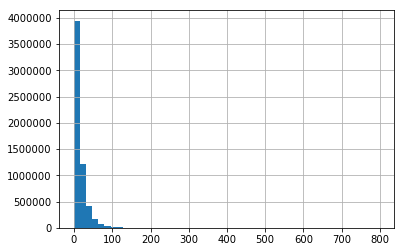

In [8]:
import matplotlib.pyplot as plt
practice_pact.quests_end.hist(bins=50)

In [9]:
print(practice_sessions.shape)
practice_sessions['actdate'] = pd.to_datetime(practice_sessions['actdate'])
practice_sessions['session_start_time'] = pd.to_datetime(practice_sessions['session_start_time'], unit='s') - practice_sessions['actdate']
practice_sessions['session_end_time'] = pd.to_datetime(practice_sessions['session_end_time'], unit='s') - practice_sessions['actdate']
practice_sessions.head(5)

(32533314, 6)


,id,session_number,session_length,session_start_time,session_end_time,actdate
0,14d94a58b7,13.0,57,18:14:49,18:15:46,2017-01-25
1,26620badd1,4.0,132,01:33:40,01:35:52,2017-01-06
2,01d7674aa8,7.0,83,21:34:41,21:36:04,2017-02-09
3,14611edffb,3.0,211,13:22:15,13:25:46,2017-02-06
4,3c13bd2cec,2.0,1206,08:37:45,08:57:51,2017-02-05


Проверим значения в выгруженных таблицах. Есть ли там пропущенные значения.

In [10]:
print('Всего', practice_dau.isnull().sum().sum() )
print(practice_dau.isnull().sum())

Всего 1715
id                  0
country          1715
number_of_pgr       0
actdate             0
dtype: int64


In [11]:
print('Всего', practice_pact.isnull().sum().sum() )
print(practice_pact.isnull().sum())

Всего 0
id                      0
actdate                 0
regdate                 0
clusters_ml_ended       0
revenue                 0
transactions            0
quests_end              0
m_quests_end            0
crystals_value_spend    0
store_enters            0
dtype: int64


In [12]:
print('Всего', practice_sessions.isnull().sum().sum() )
print(practice_sessions.isnull().sum())

Всего 23632945
id                           0
session_number        23632945
session_length               0
session_start_time           0
session_end_time             0
actdate                      0
dtype: int64


In [13]:
23632945/practice_sessions.shape[0]

0.7264229214398509

В двух таблицах есть пропущенные значения. (Спросить что с ними делать)
В таблице по сессиим нет номера сессии в 72%. Но так то это не важно. Можно восстановить по дате если понадобится.

In [14]:
for i in practice_pact.columns[3:]:
    print('%(id)s,min: %(min)s, max %(max)s, mean %(mean)s' %
          {'id': i, 'min': practice_pact[i].min(), 'max':practice_pact[i].max(), 'mean':practice_pact[i].mean() })

clusters_ml_ended,min: -2, max 98, mean 8.330775799954218
revenue,min: 0.0, max 184607.43, mean 108.17581413345603
transactions,min: 0, max 83, mean 0.024564281424404633
quests_end,min: 0, max 796, mean 15.195209524187629
m_quests_end,min: 0, max 141, mean 3.2064535257452595
crystals_value_spend,min: 0, max 0, mean 0.0
store_enters,min: 0, max 0, mean 0.0


Выберем данные с которыми будем работатью. 

Найдем дни активности пользователей совпадающие с регистрацией.

In [15]:
print('Кол-во активности в день регистрации',
      practice_pact[practice_pact['actdate'] == practice_pact['regdate']].shape)
print('Кол-во уникальных id',
      practice_pact[practice_pact['actdate'] == practice_pact['regdate']]['id'].unique().shape)

Кол-во активности в день регистрации (2060626, 10)
Кол-во уникальных id (2016708,)


Получается, что регистрация и активность дня совпадала для некоторых id.

Эти пользователи регистрировались несколько раз.

In [16]:
#Данные о первом дне всех(включая дважды зареганных)
first_day = practice_pact[practice_pact['actdate'] == practice_pact['regdate']]

In [17]:
#Те, кто регестрировался несколько раз, берем первый
first_day = pd.merge(first_day, practice_pact.groupby('id', as_index= False).min()[['id', 'regdate']], on=['id', 'regdate'], how='inner')

In [18]:
first_day = first_day[first_day['revenue'] == 0]
#Те, кто заплатил в первый день не интересны.

In [19]:
print(first_day.shape)
first_day.head()

(2009208, 10)


,id,actdate,regdate,clusters_ml_ended,revenue,transactions,quests_end,m_quests_end,crystals_value_spend,store_enters
0,abee37a4e1,2017-01-01,2017-01-01,7,0.0,0,61,13,0,0
1,6fbbafd123,2017-01-01,2017-01-01,5,0.0,0,73,14,0,0
2,23c025efd0,2017-01-01,2017-01-01,7,0.0,0,91,17,0,0
3,8f4b043ead,2017-01-01,2017-01-01,2,0.0,0,14,1,0,0
4,1bdb89a697,2017-01-01,2017-01-01,2,0.0,0,11,0,0,0


In [21]:
'''Список id для которых есть повторы
Уберу id которые дважды регистрировались
bad_id = practice_pact[practice_pact['actdate'] == practice_pact['regdate']]['id'].value_counts()[practice_pact[practice_pact['actdate'] == practice_pact['regdate']]['id'].value_counts() > 1].index
bad_id
def bad_column(id):
    return int(id in bad_id)
bad_column = practice_pact['id'].apply(bad_column)
practice_pact['bad_column_id'] = bad_column
practice_pact.drop(practice_pact[practice_pact['bad_column_id'] == 1].index, axis = 0, inplace = True)
practice_pact.drop('bad_column_id', axis = 1, inplace = True)
'''

"Список id для которых есть повторы\nbad_id = practice_pact[practice_pact['actdate'] == practice_pact['regdate']]['id'].value_counts()[practice_pact[practice_pact['actdate'] == practice_pact['regdate']]['id'].value_counts() > 1].index\nbad_id\ndef bad_column(id):\n    return int(id in bad_id)\nbad_column = practice_pact['id'].apply(bad_column)\npractice_pact['bad_column_id'] = bad_column\npractice_pact.drop(practice_pact[practice_pact['bad_column_id'] == 1].index, axis = 0, inplace = True)\npractice_pact.drop('bad_column_id', axis = 1, inplace = True)\n"

In [20]:
revenue_positive_id = practice_pact.groupby('id').sum()[practice_pact.groupby('id').sum()['revenue'] > 0].index
#Там, где будет единица в целевой переменной

In [19]:
new_data_fd = pd.merge(first_day, practice_sessions, on=['id', 'actdate'], how='inner')
#добавлю данные о сессиях в первый день

In [20]:
amount_visits_fd = pd.DataFrame(data = np.array([new_data_fd['id'].value_counts().index, new_data_fd['id'].value_counts().values]).T, columns=['id', 'amount_visits'])
#Количетсво посещений в первый день

In [21]:
first_day = pd.merge(first_day, amount_visits_fd, on=['id'], how='inner')
first_day = pd.merge(first_day, new_data_fd.groupby('id', as_index = False).sum()[['id', 'session_length']], on=['id'], how='inner')
first_day = pd.merge(first_day, new_data_fd.groupby('id', as_index = False).min()[['id', 'session_start_time','session_end_time']], on=['id'], how='inner')
#добавим к данным количество посещений,длину всех посещений в первый день и информацию о самом первом заходе

In [22]:
first_day.drop(['store_enters', 'revenue', 'regdate', 'transactions', 'crystals_value_spend'], axis = 1, inplace = True)
#они вроде нулевые => уберем

In [23]:
first_day['average_visit'] = first_day['session_length']/first_day['amount_visits']

In [24]:
first_day.head()

,id,actdate,clusters_ml_ended,quests_end,m_quests_end,amount_visits,session_length,session_start_time,session_end_time,average_visit
0,abee37a4e1,2017-01-01,7,61,13,6,5873,08:57:58,09:28:24,978.833
1,6fbbafd123,2017-01-01,5,73,14,6,7735,17:21:00,17:51:47,1289.17
2,23c025efd0,2017-01-01,7,91,17,4,6907,10:53:15,11:33:07,1726.75
3,8f4b043ead,2017-01-01,2,14,1,1,1424,21:50:46,22:14:30,1424
4,1bdb89a697,2017-01-01,2,11,0,1,521,02:52:00,03:00:41,521


Разберемся с первой таблицей. Добавим данные по стране и колчиству сообщений от устройства.

In [25]:
#у некоторых пользователей нет страны, заполним пропуск
practice_dau.fillna(value='NAN', inplace = True)

In [1]:
 country_dict = {'--': 0, 'A1': 0, 'A2': 0, 'AD': 0, 'AE': 2, 'AF': 0, 'AG': 0, 'AI': 0, 'AL': 3, 'AM': 3, 'AO': 0, 'AP': 0, 'AQ': 0, 'AR': 6, 'AS': 0, 'AT': 3, 'AU': 5, 'AW': 0, 'AX': 0, 'AZ': 2, 'BA': 3, 'BB': 0, 'BD': 2, 'BE': 3, 'BF': 0, 'BG': 3, 'BH': 3, 'BJ': 0, 'BM': 0, 'BN': 2, 'BO': 4, 'BQ': 0, 'BR': 6, 'BS': 0, 'BT': 0, 'BW': 0, 'BY': 3, 'BZ': 0, 'CA': 1, 'CD': 0, 'CG': 0, 'CH': 3, 'CI': 4, 'CL': 6, 'CM': 4, 'CN': 2, 'CO': 6, 'CR': 6, 'CU': 0, 'CV': 0, 'CW': 0, 'CY': 3, 'CZ': 3, 'DE': 3, 'DJ': 0, 'DK': 3, 'DM': 0, 'DO': 6, 'DZ': 4, 'EC': 6, 'EE': 3, 'EG': 4, 'ES': 3, 'ET': 0, 'EU': 0, 'FI': 3, 'FJ': 5, 'FM': 0, 'FO': 0, 'FR': 3, 'GA': 0, 'GB': 3, 'GD': 0, 'GE': 0, 'GF': 0, 'GG': 0, 'GH': 4, 'GI': 0, 'GL': 0, 'GM': 0, 'GN': 0, 'GP': 0, 'GQ': 0, 'GR': 3, 'GT': 6, 'GU': 0, 'GW': 0, 'GY': 0, 'HK': 2, 'HN': 6, 'HR': 3, 'HT': 6, 'HU': 3, 'ID': 2, 'IE': 3, 'IL': 2, 'IM': 0, 'IN': 2, 'IQ': 2, 'IR': 2, 'IS': 3, 'IT': 3, 'JE': 0, 'JM': 6, 'JO': 2, 'JP': 2, 'KE': 4, 'KG': 2, 'KH': 2, 'KN': 0, 'KP': 0, 'KR': 2, 'KW': 2, 'KY': 0, 'KZ': 2, 'LA': 2, 'LB': 2, 'LC': 0, 'LI': 0, 'LK': 2, 'LR': 0, 'LS': 0, 'LT': 3, 'LU': 3, 'LV': 3, 'LY': 0, 'MA': 4, 'MC': 0, 'MD': 3, 'ME': 0, 'MF': 0, 'MG': 0, 'MH': 0, 'MK': 3, 'ML': 0, 'MM': 0, 'MN': 0, 'MO': 0, 'MP': 0, 'MQ': 0, 'MR': 0, 'MT': 3, 'MU': 4, 'MV': 0, 'MX': 6, 'MY': 2, 'MZ': 4, 'NAN': 0, 'NC': 0, 'NE': 0, 'NG': 4, 'NI': 6, 'NL': 3, 'NO': 3, 'NP': 2, 'NR': 0, 'NZ': 6, 'OM': 2, 'PA': 6, 'PE': 6, 'PF': 0, 'PG': 0, 'PH': 2, 'PK': 2, 'PL': 3, 'PM': 0, 'PR': 6, 'PS': 0, 'PT': 3, 'PW': 0, 'PY': 6, 'QA': 2, 'RE': 0, 'RO': 3, 'RS': 3, 'RU': 3, 'RW': 0, 'SA': 2, 'SC': 0, 'SD': 0, 'SE': 3, 'SG': 2, 'SI': 3, 'SK': 3, 'SL': 0, 'SM': 0, 'SN': 4, 'SO': 0, 'SR': 0, 'SS': 0, 'ST': 0, 'SV': 6, 'SX': 0, 'SY': 2, 'SZ': 0, 'TG': 0, 'TH': 2, 'TJ': 0, 'TL': 0, 'TM': 2, 'TN': 4, 'TO': 0, 'TR': 2, 'TT': 6, 'TW': 2, 'TZ': 4, 'UA': 3, 'UG': 0, 'US': 1, 'UY': 6, 'UZ': 2, 'VC': 0, 'VE': 6, 'VG': 0, 'VI': 0, 'VN': 2, 'VU': 0, 'WS': 0, 'YE': 2, 'YT': 0, 'ZA': 4, 'ZM': 0, 'ZW': 0}

In [76]:
#first_day = pd.merge(first_day, practice_dau.groupby(['id', 'actdate'], as_index = False).sum(), on=['id', 'actdate'], how='inner')
#Добавим number_of_pgr в первый день

In [27]:
first_day = pd.merge(first_day, practice_dau.sort_values('number_of_pgr', ascending = 0).groupby(['id', 'actdate'], as_index = False).first(), on=['id', 'actdate'], how='inner')
#Добавим страну и number_of_pgr

In [28]:
def country_to_id(country):
    return country_dict[country]

first_day['country_id'] = first_day['country'].apply(country_to_id)
first_day.drop('country', axis = 1, inplace = True)
#Отсортируем страны по континентам

In [36]:
first_day.head()

,id,actdate,clusters_ml_ended,quests_end,m_quests_end,amount_visits,session_length,average_visit,number_of_pgr,country_id,first_session_start,first_session_end
0,abee37a4e1,2017-01-01,7,61,13,6,5873,978.833333,204,2,32278.0,34104.0
1,6fbbafd123,2017-01-01,5,73,14,6,7735,1289.166667,141,1,62460.0,64307.0
2,23c025efd0,2017-01-01,7,91,17,4,6907,1726.750000,233,3,39195.0,41587.0
3,8f4b043ead,2017-01-01,2,14,1,1,1424,1424.000000,47,3,78646.0,80070.0
4,1bdb89a697,2017-01-01,2,11,0,1,521,521.000000,19,2,10320.0,10841.0


In [30]:
first_day['amount_visits'] = first_day['amount_visits'].astype('int64')
first_day['average_visit'] = first_day['average_visit'].astype('float64')

In [31]:
def to_seconds(session_start_time):
    return session_start_time.total_seconds()
first_day['first_session_start'] = first_day['session_start_time'].apply(to_seconds)
first_day['first_session_end'] = first_day['session_end_time'].apply(to_seconds)

In [32]:
first_day.drop('session_start_time', axis = 1, inplace = True)
first_day.drop('session_end_time', axis = 1, inplace = True)

In [51]:
first_day.dtypes

clusters_ml_ended        int64
quests_end               int64
m_quests_end             int64
amount_visits            int64
session_length           int64
average_visit          float64
number_of_pgr            int64
first_session_start    float64
first_session_end      float64
country_id_0           float64
country_id_1           float64
country_id_2           float64
country_id_3           float64
country_id_4           float64
country_id_5           float64
country_id_6           float64
answer                   int64
dtype: object

Закодируем категориальный признак country_id

In [45]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
new_ohe_features = ohe.fit_transform(first_day.country_id.values.reshape(-1,1))
tmp = pd.DataFrame(new_ohe_features, columns=['country_id_' + str(i) for i in range(new_ohe_features.shape[1])])
first_day = pd.concat([first_day, tmp], axis = 1)

In [47]:
first_day.drop('country_id', axis = 1, inplace=True)

In [48]:
def cr_answer(id):
    return int(id in revenue_positive_id)

answer = first_day['id'].apply(cr_answer)
first_day['answer'] = answer

In [49]:
first_day.drop(['id', 'actdate'], axis = 1, inplace = True)

In [52]:
first_day['country_id_0'] = first_day['country_id_0'].astype('int64')
first_day['country_id_1'] = first_day['country_id_1'].astype('int64')
first_day['country_id_2'] = first_day['country_id_2'].astype('int64')
first_day['country_id_3'] = first_day['country_id_3'].astype('int64')
first_day['country_id_4'] = first_day['country_id_4'].astype('int64')
first_day['country_id_5'] = first_day['country_id_5'].astype('int64')
first_day['country_id_6'] = first_day['country_id_6'].astype('int64')
first_day['first_session_start'] = first_day['first_session_start'].astype('int64')
first_day['first_session_end'] = first_day['first_session_end'].astype('int64')

In [53]:
first_day.to_csv('first_day1.csv')

## Обучение

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier

In [540]:
first_day = pd.read_csv('first_day1.csv')
first_day.drop('Unnamed: 0', axis = 1, inplace = True) 

In [541]:
pay_persent = first_day[first_day['answer'] > 0].shape[0]/first_day.shape[0]
print('В выборке', round(pay_persent, 2), 'часть плательщиков.')

В выборке 0.01 часть плательщиков.


Что очень мало.

In [542]:
answer = first_day['answer']
first_day.drop('answer', axis = 1, inplace = True)

In [7]:
first_day.head()

,clusters_ml_ended,quests_end,m_quests_end,amount_visits,session_length,average_visit,number_of_pgr,first_session_start,first_session_end,country_id_0,country_id_1,country_id_2,country_id_3,country_id_4,country_id_5,country_id_6
0,7,61,13,6,5873,978.833333,204,32278,34104,0,0,1,0,0,0,0
1,5,73,14,6,7735,1289.166667,141,62460,64307,0,1,0,0,0,0,0
2,7,91,17,4,6907,1726.750000,233,39195,41587,0,0,0,1,0,0,0
3,2,14,1,1,1424,1424.000000,47,78646,80070,0,0,0,1,0,0,0
4,2,11,0,1,521,521.000000,19,10320,10841,0,0,1,0,0,0,0


In [543]:
#Нормализую признаки
normalizer = preprocessing.StandardScaler()
data_real_norm_np = normalizer.fit_transform(first_day)
data_real_norm_pd = pd.DataFrame(data=data_real_norm_np)

In [544]:
#обучим
X_train, X_test, y_train, y_test = train_test_split(data_real_norm_pd, answer, test_size = 0.3, random_state = 42)

## LogisticRegression 

In [545]:
#print('ROC-AUC = ', metrics.roc_auc_score(y_test, LogReg.predict_proba(X_test)[:, 1]))
print('Логистическая регрессия, нормализованные данные.')
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, LogReg.predict(X_test)).ravel()
print('Класс плательщиков: Precision = ', round(tp/(tp + fp), 4), 'Recall = ', round(tp/(tp +fn), 4),
      'Fмера = ', round(2*tp/(tp+ fp)*tp/(tp +fn)/(tp/(tp+ fp) + tp/(tp +fn)), 4) )
print('Класс бесплатных:   Precision = ', round(tn/(fn + tn), 4), 'Recall = ', round(tn/(tn +fp), 4),
      'Fмера = ', round(2*tn/(fn + tn)*tn/(tn +fp)/(tn/(fn + tn) + tn/(tn +fp)), 4) )
print('TP = ', tp, '\t FP = ', fp) 
print('FN =', fn, '\t TN = ', tn)

Логистическая регрессия, нормализованные данные.
Класс плательщиков: Precision =  0.0294 Recall =  0.0001 Fмера =  0.0003
Класс бесплатных:   Precision =  0.9887 Recall =  0.9999 Fмера =  0.9943
TP =  1 	 FP =  33
FN = 6728 	 TN =  587477


Классификатору не выгодно относить к классу плательщиков, потому что их очень мало. И почти все отнесены к другому классу. Поменяем веса в классификаторе. 

In [546]:
#print('ROC-AUC = ', metrics.roc_auc_score(y_test, LogReg.predict_proba(X_test)[:, 1]))
print('Логистическая регрессия, нормализованные данные.')
LogReg = LogisticRegression(class_weight = 'balanced')
LogReg.fit(X_train, y_train)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, LogReg.predict(X_test)).ravel()
print('Класс плательщиков: Precision = ', round(tp/(tp + fp), 4), 'Recall = ', round(tp/(tp +fn), 4),
      'Fмера = ', round(2*tp/(tp+ fp)*tp/(tp +fn)/(tp/(tp+ fp) + tp/(tp +fn)), 4) )
print('Класс бесплатных:   Precision = ', round(tn/(fn + tn), 4), 'Recall = ', round(tn/(tn +fp), 4),
      'Fмера = ', round(2*tn/(fn + tn)*tn/(tn +fp)/(tn/(fn + tn) + tn/(tn +fp)), 4) )
print('TP = ', tp, '\t FP = ', fp) 
print('FN =', fn, '\t TN = ', tn)

Логистическая регрессия, нормализованные данные.
Класс плательщиков: Precision =  0.0433 Recall =  0.822 Fмера =  0.0822
Класс бесплатных:   Precision =  0.9974 Recall =  0.7918 Fмера =  0.8828
TP =  5531 	 FP =  122318
FN = 1198 	 TN =  465192


Уже лучше. В каком-то смысле. Попробуем что-нибудь еще.

In [548]:
lr_sgd = SGDClassifier(loss="log", alpha=0.05, n_iter=200, fit_intercept=True, class_weight = 'balanced')
lr_sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.05, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=200, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [549]:
#print('ROC-AUC = ', metrics.roc_auc_score(y_test, lr_sgd.predict_proba(X_test)[:, 1]))
print('SGDClassifier, нормализованные данные.')
tn, fp, fn, tp = metrics.confusion_matrix(y_test, lr_sgd.predict(X_test)).ravel()
print('Класс плательщиков: Precision = ', round(tp/(tp + fp), 4), 'Recall = ', round(tp/(tp +fn), 4),
      'Fмера = ', round(2 * tp/(tp + fp) * tp / (tp + fn)/(tp / (tp + fp) + tp/(tp +fn)), 4) )
print('Класс бесплатных:   Precision = ', round(tn/(fn + tn), 4), 'Recall = ', round(tn/(tn +fp), 4),
      'Fмера = ', round(2*tn/(fn + tn)*tn/(tn +fp)/(tn/(fn + tn) + tn/(tn +fp)), 4) )
print('TP = ', tp, '\t FP = ', fp) 
print('FN =', fn, '\t TN = ', tn)

SGDClassifier, нормализованные данные.
Класс плательщиков: Precision =  0.044 Recall =  0.8197 Fмера =  0.0836
Класс бесплатных:   Precision =  0.9974 Recall =  0.7961 Fмера =  0.8855
TP =  5516 	 FP =  119785
FN = 1213 	 TN =  467725


In [8]:
#обучим на начальной начальной выборке
X_train, X_test, y_train, y_test = train_test_split(first_day, answer, test_size = 0.25, random_state = 42)

Так как одного класса существенно меньше чем другого, проверим ровно ли доля ответов в тестовой и тренировочной выборке.

In [9]:
print('Тренировочная:', y_train[y_train == 0].shape[0]/y_train.shape[0])
print('Тестовая:', y_test[y_test == 0].shape[0]/y_test.shape[0])

Тренировочная: 0.9887681517935214
Тестовая: 0.9885641933848817


С разбиением по классам все хорошо.
Объектов положительного класса очень мало, попробуем сбалансированный веса.

In [86]:
print('Логистическая регрессия, обычные данные.')
LogReg = LogisticRegression(class_weight = 'balanced')
LogReg.fit(X_train, y_train)
print(metrics.classification_report(y_test, LogReg.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, LogReg.predict(X_test)).T)

Логистическая регрессия, обычные данные.
             precision    recall  f1-score   support

Не заплатит       1.00      0.79      0.88    489536
   Заплатит       0.04      0.83      0.08      5663

avg / total       0.99      0.79      0.87    495199

[[387331    991]
 [102205   4672]]


In [32]:
print('Логистическая регрессия, обычные данные.')
LogReg = LogisticRegression(class_weight = {0:0.03, 1: 1})
LogReg.fit(X_train, y_train)
print(metrics.classification_report(y_test, LogReg.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, LogReg.predict(X_test)).T)

Логистическая регрессия, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.99      0.90      0.95    489536
   Заплатит       0.07      0.60      0.12      5663

avg / total       0.98      0.90      0.94    495199

[[442722   2239]
 [ 46814   3424]]


Подберем вес классов.

In [89]:
params = {
    'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0:0.05, 1:1}, 'balanced'],
}

LogRegGrid = GridSearchCV(LogisticRegression(), params, scoring='f1_macro', verbose =True)
LogRegGrid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  7.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0: 0.05, 1: 1}, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=True)

In [91]:
LogRegGrid.best_params_ #лучший вес

{'class_weight': {0: 0.1, 1: 1}}

In [92]:
print('Логистическая регрессия, обычные данные. Вес 0:0.1, 1: 1.')
LogReg = LogisticRegression(class_weight = {0: 0.1, 1: 1})
LogReg.fit(X_train, y_train)
print(metrics.classification_report(y_test, LogReg.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, LogReg.predict(X_test)).T)

Логистическая регрессия, обычные данные. Вес 0:0.1, 1: 1.
             precision    recall  f1-score   support

Не заплатит       0.99      0.98      0.98    489536
   Заплатит       0.10      0.22      0.14      5663

avg / total       0.98      0.97      0.97    495199

[[478869   4426]
 [ 10667   1237]]


### Пока лучший результат.
По данному предсказанию каждый 10 отмеченный плательщик будет верно определен. И всего должно быть отмечено 22% плательщиков. (вроде деревьями потом будет лучше)

### SGDClassifier.

In [16]:
print('SGDClassifier, обычные данные.')
lr_sgd = SGDClassifier(loss="log", alpha=0.05, n_iter=200, fit_intercept=True)
lr_sgd.fit(X_train, y_train)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, lr_sgd.predict(X_test)).ravel()
print(metrics.classification_report(y_test, lr_sgd.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, lr_sgd.predict(X_test)).T)

SGDClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.99      1.00      0.99    587510
   Заплатит       0.04      0.00      0.01      6729

avg / total       0.98      0.99      0.98    594239

[[587019   6707]
 [   491     22]]


In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

## DecisionTreeClassifier
Попробум использовать деревья. Сразу вес поставим сбалансированный.

In [106]:
DTC = DecisionTreeClassifier(class_weight = 'balanced')
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.99      0.99      0.99    489536
   Заплатит       0.06      0.05      0.06      5663

avg / total       0.98      0.98      0.98    495199

[[484666   5359]
 [  4870    304]]


Теперь настроим параметры дерева на кросс-валидации. Настраивать будем максимальную глубину, максимальное используемое на каждом разбиении число признаков и вес классов.

In [132]:
tree_params = {'max_depth': range(1,11), 'max_features': range(4,11), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0:0.05, 1:1}, 'balanced']}

In [135]:
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=3, scoring='f1_micro', verbose = True)

In [136]:
tree_grid.fit(X_train, y_train)

Fitting 3 folds for each of 350 candidates, totalling 1050 fits


[Parallel(n_jobs=1)]: Done 1050 out of 1050 | elapsed: 106.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 11), 'max_features': range(4, 11), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0: 0.05, 1: 1}, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_micro', verbose=True)

In [137]:
tree_grid.best_params_

{'class_weight': {0: 0.5, 1: 1}, 'max_depth': 1, 'max_features': 4}

In [13]:
DTC = DecisionTreeClassifier(max_depth = 1, max_features = 4, class_weight = {0: 0.5, 1: 1})
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

Не заплатит       0.99      1.00      0.99    489536
   Заплатит       0.00      0.00      0.00      5663

avg / total       0.98      0.99      0.98    495199

[[489536   5663]
 [     0      0]]


Стало хуже. Все отнеслось к одному классу. Потому что параметры настраивались по F1-микро. Попробуем F1-макро. Это среднее от F мер.

In [14]:
tree_params2 = {'max_depth': range(2,9), 'max_features': range(4,9), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, 'balanced']}

In [15]:
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params2, scoring='f1_macro', verbose = True)
tree_grid.fit(X_train, y_train)

In [17]:
tree_grid.best_params_ #лучшие параметры

{'class_weight': {0: 0.1, 1: 1}, 'max_depth': 8, 'max_features': 6}

In [20]:
DTC = DecisionTreeClassifier(max_depth = 8, max_features = 6, class_weight = {0: 0.1, 1: 1})
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.99      0.98      0.98    489536
   Заплатит       0.11      0.22      0.15      5663

avg / total       0.98      0.97      0.98    495199

[[479242   4395]
 [ 10294   1268]]


Результат очень похож на линейный классификатор, но чуть-чуть лучше.

In [550]:
print('Вероятность случайно выбрать плательщика', y_test[y_test == 1].shape[0]/y_test.shape[0])
print('Если предсказано, что не заплатит, то вероятность плательщика', 4395/(479242+4395))
print('Если предсказано, что заплатит, то вероятность плательщика', 1268/(10294+1268))

Вероятность случайно выбрать плательщика 0.01132372664870532
Если предсказано, что не заплатит, то вероятность плательщика 0.00908739405794015
Если предсказано, что заплатит, то вероятность плательщика 0.10966960733437121


In [22]:
for name, importance in zip(first_day.columns, DTC.feature_importances_):
    print(name, importance)

clusters_ml_ended 0.0185462842568
quests_end 0.532020200387
m_quests_end 0.0151493125587
amount_visits 0.004754210924
session_length 0.017661149693
average_visit 0.00818629116323
number_of_pgr 0.0431335491842
first_session_start 0.0483941650371
first_session_end 0.0171107146099
country_id_0 0.0
country_id_1 0.221742527963
country_id_2 0.0361932828017
country_id_3 0.0241206212164
country_id_4 0.00364452083475
country_id_5 0.0061506010801
country_id_6 0.00319256828989


# Посмотрим данные по IOS

Загрузим таблицы с данными.

In [759]:
dau_ios = pd.read_csv('practice_dau_ios.csv', sep='|', names = ['id', 'country','number_of_pgr', 'actdate'])
print('dau_ios:', dau_ios.shape)

pact_ios = pd.read_csv('practice_pact_ios.csv', sep='|', names = ['id', 'actdate', 'regdate', 'clusters_ml_ended',
                                                                      'revenue', 'transactions', 'quests_end',
                                                                       'm_quests_end', 'crystals_value_spend',
                                                                       'store_enters'])
print('pact_ios:', pact_ios.shape)

sessions_ios = pd.read_csv('practice_sessions_ios.csv', sep='|', names = ['id', 'session_number','session_length',
                                                                              'session_start_time', 'session_end_time',
                                                                              'actdate'])
print('sessions_ios:', sessions_ios.shape)

dau_ios: (1725891, 4)
pact_ios: (1051248, 10)
sessions_ios: (7534075, 6)


In [760]:
dau_ios['actdate'] = pd.to_datetime(dau_ios['actdate'])
dau_ios.head(5)

,id,country,number_of_pgr,actdate
0,c1d690f4ce,AU,9,2017-02-21
1,c1d690f4ce,AU,32,2017-02-18
2,c1d690f4ce,AU,11,2017-02-12
3,c1d690f4ce,AU,2,2017-02-17
4,c1d690f4ce,AU,4,2017-02-16


In [761]:
pact_ios['actdate'] = pd.to_datetime(pact_ios['actdate'])
pact_ios['regdate'] = pd.to_datetime(pact_ios['regdate'])
pact_ios.head(5)

,id,actdate,regdate,clusters_ml_ended,revenue,transactions,quests_end,m_quests_end,crystals_value_spend,store_enters
0,767bc9dfd3,2017-01-01,2017-01-01,1,0.0,0,9,0,0,0
1,249241537d,2017-01-01,2017-01-01,3,0.0,0,49,7,0,0
2,740d34570d,2017-01-01,2017-01-01,7,0.0,0,138,25,0,0
3,d288a3fd89,2017-01-02,2017-01-02,-2,0.0,0,0,0,0,0
4,ed716df037,2017-01-02,2017-01-01,2,0.0,0,3,1,0,0


In [762]:
sessions_ios['actdate'] = pd.to_datetime(sessions_ios['actdate'])
sessions_ios['session_start_time'] = pd.to_datetime(sessions_ios['session_start_time'], unit='s') - sessions_ios['actdate']
sessions_ios['session_end_time'] = pd.to_datetime(sessions_ios['session_end_time'], unit='s') - sessions_ios['actdate']
sessions_ios.head(5)

,id,session_number,session_length,session_start_time,session_end_time,actdate
0,00e954a1b3,12.0,29,14:46:40,14:47:09,2017-02-13
1,028498cd03,1.0,445,22:56:16,23:03:41,2017-01-21
2,12ab1dfa82,8.0,0,20:00:15,20:00:15,2017-02-10
3,0a0a1ffe3b,5.0,2846,05:28:14,06:15:40,2017-01-21
4,01c68437aa,7.0,1610,17:42:12,18:09:02,2017-01-13


Подробнее рассмотрим содержание таблиц.

In [763]:
# пропущенные значения
print('Всего в dau:', dau_ios.isnull().sum().sum())
print(dau_ios.isnull().sum())
print('\nВсего в pact:', pact_ios.isnull().sum().sum())
print(pact_ios.isnull().sum())
print('\nВсего в sessions:', sessions_ios.isnull().sum().sum())
print(sessions_ios.isnull().sum())

Всего в dau: 119
id                 0
country          119
number_of_pgr      0
actdate            0
dtype: int64

Всего в pact: 0
id                      0
actdate                 0
regdate                 0
clusters_ml_ended       0
revenue                 0
transactions            0
quests_end              0
m_quests_end            0
crystals_value_spend    0
store_enters            0
dtype: int64

Всего в sessions: 5938809
id                          0
session_number        5938809
session_length              0
session_start_time          0
session_end_time            0
actdate                     0
dtype: int64


Рассмотрим немного подробнее таблицу pact_ios

In [764]:
for i in pact_ios.columns[3:]:
    print('%(id)s, min: %(min)s, max %(max)s, mean %(mean)s' %
          {'id': i, 'min': pact_ios[i].min(), 'max': pact_ios[i].max(), 'mean': pact_ios[i].mean() })

clusters_ml_ended, min: -2, max 98, mean 11.138065423192243
revenue, min: 0.0, max 527875.3, mean 352.19439268380194
transactions, min: 0, max 54, mean 0.054720674855029454
quests_end, min: 0, max 652, mean 14.843081746647794
m_quests_end, min: 0, max 96, mean 3.3794528027639528
crystals_value_spend, min: 0, max 0, mean 0.0
store_enters, min: 0, max 0, mean 0.0


Выберем данные для работы. Так как смотреть надо по первому дню, выделю их.

In [765]:
print('Кол-во активности в день регистрации',
      pact_ios[pact_ios['actdate'] == pact_ios['regdate']].shape)
print('Кол-во уникальных id',
      pact_ios[pact_ios['actdate'] == pact_ios['regdate']]['id'].unique().shape)

Кол-во активности в день регистрации (178916, 10)
Кол-во уникальных id (173795,)


In [766]:
#Данные о первом дне всех(включая дважды зареганных)
fd_ios = pact_ios[pact_ios['actdate'] == pact_ios['regdate']]

Есть пользователи, которые регестрировались несколько раз возьму первый.

In [767]:
#Те, кто регестрировался несколько раз, берем первый
fd_ios = pd.merge(fd_ios, pact_ios.groupby('id', as_index= False).min()[['id', 'regdate']], on=['id', 'regdate'], how='inner')

In [ ]:
fd_ios = fd_ios[fd_ios['revenue'] == 0]
#Те, кто заплатил в первый день не интересны.

In [768]:
fd_sessions = pd.merge(fd_ios, sessions_ios, on=['id', 'actdate'], how='inner')
#добавлю данные о сессиях в первый день

In [769]:
amount_visits_fd = pd.DataFrame(data = np.array([fd_sessions['id'].value_counts().index, fd_sessions['id'].value_counts().values]).T, columns=['id', 'amount_visits'])
#Количетсво посещений в первый день

In [770]:
fd_ios = pd.merge(fd_ios, amount_visits_fd, on=['id'], how='inner')
fd_ios = pd.merge(fd_ios, fd_sessions.groupby('id', as_index = False).sum()[['id', 'session_length']], on=['id'], how='inner')
fd_ios = pd.merge(fd_ios, fd_sessions.groupby('id', as_index = False).min()[['id', 'session_start_time','session_end_time']], on=['id'], how='inner')
fd_ios = pd.merge(fd_ios, fd_sessions.groupby('id', as_index = False).min()[['id', 'session_length']].rename(columns={'session_length': 'min_length'}), on=['id'], how='inner')
fd_ios = pd.merge(fd_ios, fd_sessions.groupby('id', as_index = False).max()[['id', 'session_length']].rename(columns={'session_length': 'max_length'}), on=['id'], how='inner')
#добавим к данным количество посещений,длину всех посещений в первый день и информацию о самом первом заходе, максимальном заходе

In [771]:
std_sess = fd_sessions.groupby('id').std().rename(columns={'session_length': 'std_session_length'})['std_session_length']
std_sess = pd.DataFrame(std_sess)
std_sess.fillna(value = 0, inplace = True)
std_sess = std_sess.reset_index()
fd_ios = pd.merge(fd_ios, std_sess, on=['id'], how='inner')

In [772]:
fd_ios.drop(['store_enters', 'revenue', 'regdate', 'transactions', 'crystals_value_spend'], axis = 1, inplace = True)
#они вроде нулевые => уберем

In [773]:
fd_ios['average_visit'] = fd_ios['session_length']/fd_ios['amount_visits']

In [774]:
#у некоторых пользователей нет страны, заполним пропуск
dau_ios.fillna(value='NAN', inplace = True)

In [775]:
# - other, 1 - North America, 2 - Azia, 3 - Europe, 4 - Africa, 5 -  Australia, 6 - South America
country_dict = {'--': 0, 'TC': 5, 'MS': 5, 'TD': 4, 'A1': 0, 'A2': 0, 'AD': 0, 'AE': 2, 'AF': 0, 'AG': 0, 'AI': 0, 'AL': 3, 'AM': 3, 'AO': 0, 'AP': 0, 'AQ': 0, 'AR': 6, 'AS': 0, 'AT': 3, 'AU': 5, 'AW': 0, 'AX': 0, 'AZ': 2, 'BA': 3, 'BB': 0, 'BD': 2, 'BE': 3, 'BF': 0, 'BG': 3, 'BH': 3, 'BJ': 0, 'BM': 0, 'BN': 2, 'BO': 4, 'BQ': 0, 'BR': 6, 'BS': 0, 'BT': 0, 'BW': 0, 'BY': 3, 'BZ': 0, 'CA': 1, 'CD': 0, 'CG': 0, 'CH': 3, 'CI': 4, 'CL': 6, 'CM': 4, 'CN': 2, 'CO': 6, 'CR': 6, 'CU': 0, 'CV': 0, 'CW': 0, 'CY': 3, 'CZ': 3, 'DE': 3, 'DJ': 0, 'DK': 3, 'DM': 0, 'DO': 6, 'DZ': 4, 'EC': 6, 'EE': 3, 'EG': 4, 'ES': 3, 'ET': 0, 'EU': 0, 'FI': 3, 'FJ': 5, 'FM': 0, 'FO': 0, 'FR': 3, 'GA': 0, 'GB': 3, 'GD': 0, 'GE': 0, 'GF': 0, 'GG': 0, 'GH': 4, 'GI': 0, 'GL': 0, 'GM': 0, 'GN': 0, 'GP': 0, 'GQ': 0, 'GR': 3, 'GT': 6, 'GU': 0, 'GW': 0, 'GY': 0, 'HK': 2, 'HN': 6, 'HR': 3, 'HT': 6, 'HU': 3, 'ID': 2, 'IE': 3, 'IL': 2, 'IM': 0, 'IN': 2, 'IQ': 2, 'IR': 2, 'IS': 3, 'IT': 3, 'JE': 0, 'JM': 6, 'JO': 2, 'JP': 2, 'KE': 4, 'KG': 2, 'KH': 2, 'KN': 0, 'KP': 0, 'KR': 2, 'KW': 2, 'KY': 0, 'KZ': 2, 'LA': 2, 'LB': 2, 'LC': 0, 'LI': 0, 'LK': 2, 'LR': 0, 'LS': 0, 'LT': 3, 'LU': 3, 'LV': 3, 'LY': 0, 'MA': 4, 'MC': 0, 'MD': 3, 'ME': 0, 'MF': 0, 'MG': 0, 'MH': 0, 'MK': 3, 'ML': 0, 'MM': 0, 'MN': 0, 'MO': 0, 'MP': 0, 'MQ': 0, 'MR': 0, 'MT': 3, 'MU': 4, 'MV': 0, 'MX': 6, 'MY': 2, 'MZ': 4, 'NAN': 0, 'NC': 0, 'NE': 0, 'NG': 4, 'NI': 6, 'NL': 3, 'NO': 3, 'NP': 2, 'NR': 0, 'NZ': 6, 'OM': 2, 'PA': 6, 'PE': 6, 'PF': 0, 'PG': 0, 'PH': 2, 'PK': 2, 'PL': 3, 'PM': 0, 'PR': 6, 'PS': 0, 'PT': 3, 'PW': 0, 'PY': 6, 'QA': 2, 'RE': 0, 'RO': 3, 'RS': 3, 'RU': 3, 'RW': 0, 'SA': 2, 'SC': 0, 'SD': 0, 'SE': 3, 'SG': 2, 'SI': 3, 'SK': 3, 'SL': 0, 'SM': 0, 'SN': 4, 'SO': 0, 'SR': 0, 'SS': 0, 'ST': 0, 'SV': 6, 'SX': 0, 'SY': 2, 'SZ': 0, 'TG': 0, 'TH': 2, 'TJ': 0, 'TL': 0, 'TM': 2, 'TN': 4, 'TO': 0, 'TR': 2, 'TT': 6, 'TW': 2, 'TZ': 4, 'UA': 3, 'UG': 0, 'US': 1, 'UY': 6, 'UZ': 2, 'VC': 0, 'VE': 6, 'VG': 0, 'VI': 0, 'VN': 2, 'VU': 0, 'WS': 0, 'YE': 2, 'YT': 0, 'ZA': 4, 'ZM': 0, 'ZW': 0}

In [776]:
fd_ios = pd.merge(fd_ios, dau_ios.sort_values('number_of_pgr', ascending = 0).groupby(['id', 'actdate'], as_index = False).first(), on=['id', 'actdate'], how='inner')
#Добавим страну и number_of_pgr

In [777]:
def country_to_id(country):
    return country_dict[country]

fd_ios['continent'] = fd_ios['country'].apply(country_to_id)

In [778]:
fd_ios['amount_visits'] = fd_ios['amount_visits'].astype('int64')
fd_ios['average_visit'] = fd_ios['average_visit'].astype('float64')

In [779]:
country_rang = {'US': 1, 'FR': 2, 'GB': 2, 'DE': 2, 'CA': 4, 'RU': 2, 'AU': 4, 'SG': 4, 'PH': 4, 'CH': 2, 'IN': 4}
#1 - US, 2 - top Europe, 3 - other Europe, 4 - top Other World, 5 - Other Other World.

In [780]:
for i in dau_ios['country'].value_counts().index:
    if i in country_rang:
        continue
    else:
        if country_dict[i] == 3:
            country_rang[i] = 3
        else:
            country_rang[i] = 5

In [781]:
def country_to_rang(country):
    return country_rang[country]

fd_ios['country_rang'] = fd_ios['country'].apply(country_to_rang)

In [782]:
def to_seconds(session_start_time):
    return session_start_time.total_seconds()
fd_ios['first_session_start'] = fd_ios['session_start_time'].apply(to_seconds)
fd_ios['first_session_end'] = fd_ios['session_end_time'].apply(to_seconds)
fd_ios.drop('session_start_time', axis = 1, inplace = True)
fd_ios.drop('session_end_time', axis = 1, inplace = True)

In [783]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
new_ohe_features = ohe.fit_transform(fd_ios.continent.values.reshape(-1,1))
tmp = pd.DataFrame(new_ohe_features, columns=['continent_' + str(i) for i in range(new_ohe_features.shape[1])])
fd_ios = pd.concat([fd_ios, tmp], axis = 1)

In [784]:
ohe = OneHotEncoder(sparse = False)
new_ohe_features = ohe.fit_transform(fd_ios.country_rang.values.reshape(-1,1))
tmp = pd.DataFrame(new_ohe_features, columns=['contry_rang_' + str(i) for i in range(new_ohe_features.shape[1])])
fd_ios = pd.concat([fd_ios, tmp], axis = 1)

In [785]:
fd_ios.drop('continent', axis = 1, inplace=True)
fd_ios.drop('country', axis = 1, inplace = True)
fd_ios.drop('country_rang', axis = 1, inplace=True)

In [786]:
positive_id = pact_ios.groupby('id').sum()[pact_ios.groupby('id').sum()['revenue'] > 0].index
#Там, где будет единица в целевой переменной

In [787]:
def cr_answer(id):
    return int(id in positive_id)

fd_ios['answer'] = fd_ios['id'].apply(cr_answer)
answer = fd_ios['answer']

In [788]:
fd_ios.head(5)

,id,actdate,clusters_ml_ended,quests_end,m_quests_end,amount_visits,session_length,min_length,max_length,std_session_length,...,continent_3,continent_4,continent_5,continent_6,contry_rang_0,contry_rang_1,contry_rang_2,contry_rang_3,contry_rang_4,answer
0,767bc9dfd3,2017-01-01,1,9,0,1,577,577,577,0.000000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,249241537d,2017-01-01,3,49,7,4,3057,0,1145,522.086439,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,740d34570d,2017-01-01,7,138,25,6,14800,215,10391,3910.096606,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,d288a3fd89,2017-01-02,-2,0,0,1,0,0,0,0.000000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,a0c40aa289,2017-01-02,5,40,8,1,1875,1875,1875,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [789]:
#fd_ios.drop(['id', 'actdate'], axis = 1, inplace = True)
fd_ios['continent_0'] = fd_ios['continent_0'].astype('int64')
fd_ios['continent_1'] = fd_ios['continent_1'].astype('int64')
fd_ios['continent_2'] = fd_ios['continent_2'].astype('int64')
fd_ios['continent_3'] = fd_ios['continent_3'].astype('int64')
fd_ios['continent_4'] = fd_ios['continent_4'].astype('int64')
fd_ios['continent_5'] = fd_ios['continent_5'].astype('int64')
fd_ios['continent_6'] = fd_ios['continent_6'].astype('int64')
fd_ios['contry_rang_1'] = fd_ios['contry_rang_1'].astype('int64')
fd_ios['contry_rang_2'] = fd_ios['contry_rang_2'].astype('int64')
fd_ios['contry_rang_3'] = fd_ios['contry_rang_3'].astype('int64')
fd_ios['contry_rang_4'] = fd_ios['contry_rang_4'].astype('int64')
fd_ios['contry_rang_0'] = fd_ios['contry_rang_0'].astype('int64')
fd_ios['first_session_start'] = fd_ios['first_session_start'].astype('int64')
fd_ios['first_session_end'] = fd_ios['first_session_end'].astype('int64')

In [790]:
pay_persent_ios = fd_ios[fd_ios['answer'] > 0].shape[0]/fd_ios.shape[0]
print('В выборке', round(pay_persent_ios, 3), 'часть плательщиков.')

В выборке 0.059 часть плательщиков.


In [555]:
fd_ios['answer'] = answer

In [791]:
#fd_ios.to_csv('fd_ios_with_id.csv')

In [277]:
fd_ios.to_csv('fd_ios.csv')

In [725]:
fd_ios = pd.read_csv('fd_ios.csv')

In [792]:
answer = fd_ios['answer']
fd_ios.drop('answer', axis = 1, inplace = True)

# Обучение

In [318]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [728]:
#разделим выборку на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(fd_ios, answer, test_size = 0.25, random_state = 42)

## Decision Tree Classifier

In [280]:
DTC = DecisionTreeClassifier(class_weight = 'balanced')
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.95      0.95      0.95     40267
   Заплатит       0.20      0.20      0.20      2463

avg / total       0.91      0.91      0.91     42730

[[38265  1970]
 [ 2002   493]]


In [248]:
tree_params = {'max_depth': range(1,12), 'max_features': range(4,13), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0:0.05, 1:1}, 'balanced']}

In [249]:
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring='f1_macro', verbose = True)
tree_grid.fit(X_train, y_train)

In [251]:
tree_grid.best_params_

{'class_weight': {0: 0.2, 1: 1}, 'max_depth': 6, 'max_features': 11}

In [435]:
DTC = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 1}, max_depth = 6, max_features = 11)
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.96      0.94      0.95     40267
   Заплатит       0.28      0.39      0.32      2463

avg / total       0.92      0.91      0.91     42730

[[37769  1513]
 [ 2498   950]]


In [436]:
feature_importances = []
for name, importance in zip(fd_ios.columns, DTC.feature_importances_):
    feature_importances.append([name, importance])

In [437]:
feature_importances.sort(key = lambda x: -x[1])
feature_importances = pd.DataFrame(feature_importances, columns = ['feature', 'importance'])

Важность признаков в DecisionTreeClassifier. Топ 10.


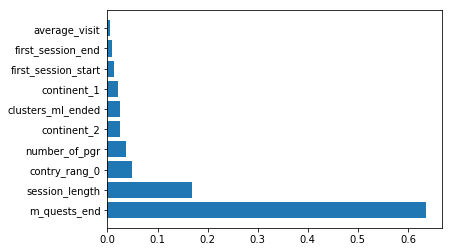

In [439]:
print('Важность признаков в DecisionTreeClassifier. Топ 10.')
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.barh(range(10), feature_importances.importance[0:10])
plt.yticks(range(10), feature_importances.feature[0:10])
plt.show()

## RandomForestClassifier

In [379]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=100,  max_depth = 6, max_features = 11, class_weight = {0: 0.2, 1: 1})
RFC = RFC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, RFC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, RFC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.96      0.95      0.95     40267
   Заплатит       0.30      0.38      0.34      2463

avg / total       0.92      0.91      0.92     42730

[[38113  1534]
 [ 2154   929]]


In [444]:
feature_importances_RFC = []
for name, importance in zip(fd_ios.columns, RFC.feature_importances_):
    feature_importances_RFC.append([name, importance])
feature_importances_RFC.sort(key = lambda x: -x[1])
feature_importances_RFC = pd.DataFrame(feature_importances_RFC, columns = ['feature', 'importance'])

Важность признаков(RandomForestClassifier). Топ 15


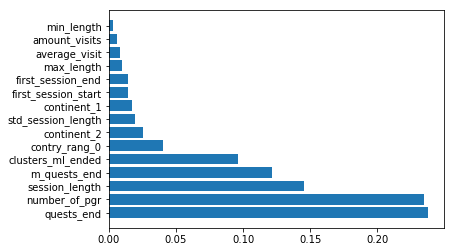

In [448]:
print('Важность признаков(RandomForestClassifier). Топ 15')
plt.figure()
plt.barh(range(15), feature_importances_RFC.importance[0:15])
plt.yticks(range(15), feature_importances_RFC.feature[0:15])
plt.show()

## Метрика Lift

In [451]:
y_pred = RFC.predict(X_test) # порог 0.5
y_pred_proba = RFC.predict_proba(X_test)[:,1]

In [455]:
lift_df = pd.DataFrame({'probability': y_pred_proba, 'real_answer': y_test, 'answer': y_pred})
lift_df.sort_values('probability',ascending=False,inplace=True)
lift_df.head()

,answer,probability,real_answer
113448,1,0.982094,1
115972,1,0.981548,1
125035,1,0.981238,1
23082,1,0.981238,1
74649,1,0.981223,1


In [475]:
propotion_10 = lift_df['real_answer'][:int(lift_df.shape[0]/10)].sum()/ (lift_df.shape[0]/10) #доля плательщиков в 10 процентах

In [474]:
propotion_all = lift_df['real_answer'].sum()/lift_df.shape[0]

Собственно сам Lift

In [477]:
#lift
print('lift:', propotion_10/propotion_all)

lift: 4.42549736094194


In [486]:
lift_df['real_answer'].sum()

2463

In [534]:
lift_table = [[0, 0, 0, 0, 0, 0, 0]]
positive = 0
random_variant = lift_df['real_answer'].sum()/10
rv_sum = 0
for i in range(10, 110, 10):
    cur_positive = lift_df['real_answer'][ int((i - 10) * lift_df.shape[0]/100 ) : int(i * lift_df.shape[0]/100)].sum()
    positive += cur_positive
    rv_sum += random_variant
    lift_table.append([i, cur_positive, positive, random_variant, rv_sum, round(cur_positive/2463, 3), round(random_variant/2463, 2)])
lift_table = pd.DataFrame(lift_table, columns = ['percent', 'prediction_answer', 'prediction_sum', 'random_answer',
                                                 'random_sum', 'pred_percent', 'random_percent'])

In [535]:
lift_table['sum_pred_percent'] = lift_table['pred_percent'].cumsum()*100
lift_table['sum_random_percent'] = lift_table['random_percent'].cumsum()*100

In [536]:
lift_table

,percent,prediction_answer,prediction_sum,random_answer,random_sum,pred_percent,random_percent,sum_pred_percent,sum_random_percent
0,0,0,0,0.0,0.0,0.000,0.0,0.0,0.0
1,10,1090,1090,246.3,246.3,0.443,0.1,44.3,10.0
2,20,489,1579,246.3,492.6,0.199,0.1,64.2,20.0
3,30,305,1884,246.3,738.9,0.124,0.1,76.6,30.0
4,40,211,2095,246.3,985.2,0.086,0.1,85.2,40.0
5,50,144,2239,246.3,1231.5,0.058,0.1,91.0,50.0
6,60,87,2326,246.3,1477.8,0.035,0.1,94.5,60.0
7,70,48,2374,246.3,1724.1,0.019,0.1,96.4,70.0
8,80,46,2420,246.3,1970.4,0.019,0.1,98.3,80.0
9,90,25,2445,246.3,2216.7,0.010,0.1,99.3,90.0


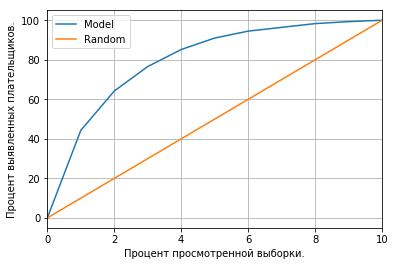

In [539]:
plt.figure()
lift_table['sum_pred_percent'].plot(label='Model')
lift_table['sum_random_percent'].plot(label='Random')
plt.ylabel('Процент выявленных плательщиков.')
plt.xlabel('Процент просмотренной выборки.')
plt.legend()
plt.grid(True)
plt.show()

## GradientBoostingClassifier

In [350]:
grad_params1 = {'n_estimators': [200, 100, 50], 'learning_rate': [1, 0.5, 0.1, 0.05]}
grad_params2 = {'max_depth': range(1, 13, 2), 'max_features': range(6,17)}

In [347]:
grad_grid = GridSearchCV(GradientBoostingClassifier(), grad_params1, scoring='f1_macro', verbose=True)
grad_grid.fit(X_train, y_train)

In [353]:
%time
grad_grid = GridSearchCV(GradientBoostingClassifier(), grad_params2, scoring='f1_macro', verbose=True)
grad_grid.fit(X_train, y_train)

Wall time: 0 ns
Fitting 3 folds for each of 66 candidates, totalling 198 fits


[Parallel(n_jobs=1)]: Done 198 out of 198 | elapsed: 145.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 13, 2), 'max_features': range(6, 17)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=True)

In [349]:
grad_grid.best_params_

{'learning_rate': 0.5, 'n_estimators': 200}

In [354]:
grad_grid.best_params_

{'max_depth': 11, 'max_features': 13}

In [729]:
GBC = GradientBoostingClassifier(n_estimators=200,  max_depth = 11, max_features = 13, learning_rate = 0.5)
GBC = GBC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, GBC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, GBC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.95      0.98      0.96     40267
   Заплатит       0.29      0.14      0.19      2463

avg / total       0.91      0.93      0.92     42730

[[39385  2111]
 [  882   352]]


## Предсказание по первым двум/трем дням в игре

In [793]:
pact_ios.sort_values(['id', 'actdate'] ,ascending=[True, True],inplace=True) #отсортируем по id и дням захода в игру

In [794]:
days_id = dict() 
def day_search(id):
    if id not in days_id:
        days_id[id] = 1
    else:
        days_id[id] += 1
    return days_id[id]

In [795]:
pact_ios['day_number'] = pact_ios['id'].apply(day_search) #колонка с номером входа в игру

In [796]:
sd_ios = pact_ios[pact_ios['day_number'] == 2] #второй день игры
td_ios = pact_ios[pact_ios['day_number'] == 3] #третий день игры

In [797]:
sd_sessions = pd.merge(sd_ios, sessions_ios, on=['id', 'actdate'], how='inner')
amount_visits_sd = pd.DataFrame(data = np.array([sd_sessions['id'].value_counts().index, sd_sessions['id'].value_counts().values]).T, columns=['id', 'amount_visits'])
#Количетсво посещений во второй день
sd_ios = pd.merge(sd_ios, amount_visits_sd, on=['id'], how='inner')
sd_ios = pd.merge(sd_ios, sd_sessions.groupby('id', as_index = False).sum()[['id', 'session_length']], on=['id'], how='inner')
sd_ios = pd.merge(sd_ios, sd_sessions.groupby('id', as_index = False).min()[['id', 'session_start_time','session_end_time']], on=['id'], how='inner')
sd_ios = pd.merge(sd_ios, sd_sessions.groupby('id', as_index = False).min()[['id', 'session_length']].rename(columns={'session_length': 'min_length'}), on=['id'], how='inner')
sd_ios = pd.merge(sd_ios, sd_sessions.groupby('id', as_index = False).max()[['id', 'session_length']].rename(columns={'session_length': 'max_length'}), on=['id'], how='inner')
#добавим к данным количество посещений,длину всех посещений во второй день, информацию о самом первом заходе, максимальный заход
std_sess_sd = sd_sessions.groupby('id').std().rename(columns={'session_length': 'std_session_length'})['std_session_length']
std_sess_sd = pd.DataFrame(std_sess_sd)
std_sess_sd.fillna(value = 0, inplace = True)
std_sess_sd = std_sess_sd.reset_index()
sd_ios = pd.merge(sd_ios, std_sess_sd, on=['id'], how='inner')
#добавлю std по сессиям
sd_ios.drop(['store_enters', 'revenue', 'regdate', 'transactions', 'crystals_value_spend'], axis = 1, inplace = True)
#они вроде нулевые => уберем

sd_ios['average_visit'] = sd_ios['session_length']/sd_ios['amount_visits']

sd_ios = pd.merge(sd_ios, dau_ios.sort_values('number_of_pgr', ascending = 0).groupby(['id', 'actdate'], as_index = False).first(), on=['id', 'actdate'], how='inner')
#Добавим страну и number_of_pgr
sd_ios.drop('country', axis = 1, inplace = True)#уберем страну, она уже есть

sd_ios['amount_visits'] = sd_ios['amount_visits'].astype('int64')
sd_ios['average_visit'] = sd_ios['average_visit'].astype('float64')

def to_seconds(session_start_time):
    return session_start_time.total_seconds()

sd_ios['first_session_start'] = sd_ios['session_start_time'].apply(to_seconds)
sd_ios['first_session_end'] = sd_ios['session_end_time'].apply(to_seconds)
sd_ios.drop('session_start_time', axis = 1, inplace = True)
sd_ios.drop('session_end_time', axis = 1, inplace = True)

sd_ios['first_session_start'] = sd_ios['first_session_start'].astype('int64')
sd_ios['first_session_end'] = sd_ios['first_session_end'].astype('int64')

In [799]:
sd_ios.dtypes

id                             object
actdate                datetime64[ns]
clusters_ml_ended               int64
quests_end                      int64
m_quests_end                    int64
day_number                      int64
amount_visits                   int64
session_length                  int64
min_length                      int64
max_length                      int64
std_session_length            float64
average_visit                 float64
number_of_pgr                   int64
first_session_start             int64
first_session_end               int64
dtype: object

In [800]:
td_sessions = pd.merge(td_ios, sessions_ios, on=['id', 'actdate'], how='inner')
amount_visits_td = pd.DataFrame(data = np.array([td_sessions['id'].value_counts().index, td_sessions['id'].value_counts().values]).T, columns=['id', 'amount_visits'])
#Количетсво посещений во третий день
td_ios = pd.merge(td_ios, amount_visits_td, on=['id'], how='inner')
td_ios = pd.merge(td_ios, td_sessions.groupby('id', as_index = False).sum()[['id', 'session_length']], on=['id'], how='inner')
td_ios = pd.merge(td_ios, td_sessions.groupby('id', as_index = False).min()[['id', 'session_start_time','session_end_time']], on=['id'], how='inner')
td_ios = pd.merge(td_ios, td_sessions.groupby('id', as_index = False).min()[['id', 'session_length']].rename(columns={'session_length': 'min_length'}), on=['id'], how='inner')
td_ios = pd.merge(td_ios, td_sessions.groupby('id', as_index = False).max()[['id', 'session_length']].rename(columns={'session_length': 'max_length'}), on=['id'], how='inner')
#добавим к данным количество посещений,длину всех посещений во третий день, информацию о самом первом заходе, максимальный заход
std_sess_td = td_sessions.groupby('id').std().rename(columns={'session_length': 'std_session_length'})['std_session_length']
std_sess_td = pd.DataFrame(std_sess_td)
std_sess_td.fillna(value = 0, inplace = True)
std_sess_td = std_sess_td.reset_index()
td_ios = pd.merge(td_ios, std_sess_td, on=['id'], how='inner')
#добавлю std по сессиям
td_ios.drop(['store_enters', 'revenue', 'regdate', 'transactions', 'crystals_value_spend'], axis = 1, inplace = True)
#они вроде нулевые => уберем

td_ios['average_visit'] = td_ios['session_length']/td_ios['amount_visits']

td_ios = pd.merge(td_ios, dau_ios.sort_values('number_of_pgr', ascending = 0).groupby(['id', 'actdate'], as_index = False).first(), on=['id', 'actdate'], how='inner')
#Добавим страну и number_of_pgr
td_ios.drop('country', axis = 1, inplace = True)#уберем страну, она уже есть

td_ios['amount_visits'] = td_ios['amount_visits'].astype('int64')
td_ios['average_visit'] = td_ios['average_visit'].astype('float64')

def to_seconds(session_start_time):
    return session_start_time.total_seconds()

td_ios['first_session_start'] = td_ios['session_start_time'].apply(to_seconds)
td_ios['first_session_end'] = td_ios['session_end_time'].apply(to_seconds)
td_ios.drop('session_start_time', axis = 1, inplace = True)
td_ios.drop('session_end_time', axis = 1, inplace = True)

td_ios['first_session_start'] = td_ios['first_session_start'].astype('int64')
td_ios['first_session_end'] = td_ios['first_session_end'].astype('int64')

In [801]:
for i in td_ios.columns[1:]:
    new_name = 'td_' + i
    td_ios.rename(columns = {i: new_name}, inplace = True)

In [802]:
for i in sd_ios.columns[1:]:
    new_name = 'sd_' + i
    sd_ios.rename(columns = {i: new_name}, inplace = True)

In [803]:
fd_ios.shape

(170919, 26)

In [804]:
sd_ios.shape

(84856, 15)

In [805]:
fsd_ios = pd.merge(fd_ios, sd_ios, on=['id'], how='left')

In [806]:
fstd_ios = pd.merge(fsd_ios, td_ios, on=['id'], how='left')#данные по первому, второму и третьему дню

In [686]:
del(fsd_ios)

In [807]:
#заполним пропущенные значения
fstd_ios.fillna(0, inplace = True)

In [808]:
fstd_ios.isnull().sum().sum()

0

In [809]:
#fstd_ios.to_csv('fstd_ios.csv')

In [814]:
#fstd_ios = pd.read_csv('fstd_ios.csv')

In [815]:
def days_count(date):
    if date == pd.to_datetime('1970-01-01'):
        return 0
    return 1

fstd_ios['num_days_played'] = fstd_ios['actdate'].apply(days_count) + fstd_ios['sd_actdate'].apply(days_count) + fstd_ios['td_actdate'].apply(days_count)

In [816]:
positive_id = pact_ios.groupby('id').sum()[pact_ios.groupby('id').sum()['revenue'] > 0].index
def cr_answer(id):
    return int(id in positive_id)

fstd_ios['answer'] = fstd_ios['id'].apply(cr_answer)
answer = fstd_ios['answer']

In [817]:
fstd_ios.drop(['id', 'actdate', 'sd_actdate', 'td_actdate'], axis = 1, inplace = True)

In [818]:
fstd_ios.drop('answer', axis = 1, inplace = True)

In [820]:
#разделим выборку на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(fstd_ios, answer, test_size = 0.25, random_state = 42)

In [821]:
DTC = DecisionTreeClassifier(class_weight = 'balanced')
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.96      0.96      0.96     40267
   Заплатит       0.33      0.33      0.33      2463

avg / total       0.92      0.92      0.92     42730

[[38584  1648]
 [ 1683   815]]


In [830]:
tree_params = {'max_depth': range(2,13), 'max_features': range(7,19), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0:0.05, 1:1}]}

In [823]:
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring='f1_macro', verbose = True)
tree_grid.fit(X_train, y_train)

In [825]:
tree_grid.best_params_

{'class_weight': {0: 0.5, 1: 1}, 'max_depth': 7, 'max_features': 18}

In [835]:
DTC = DecisionTreeClassifier(class_weight = {0: 0.5, 1: 1}, max_depth = 7, max_features = 18)
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.5, 1: 1}, max_depth = 7, max_features = 18')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.5, 1: 1}, max_depth = 7, max_features = 18
             precision    recall  f1-score   support

Не заплатит       0.96      0.98      0.97     40267
   Заплатит       0.54      0.34      0.42      2463

avg / total       0.94      0.95      0.94     42730

[[39539  1614]
 [  728   849]]


In [857]:
RFC = RandomForestClassifier(n_estimators=100,  max_depth = 7, max_features = 18, class_weight = {0: 0.5, 1: 1})
RFC = RFC.fit(X_train, y_train)
print('RandomForestClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.5, 1: 1}, max_depth = 7, max_features = 18')
print(metrics.classification_report(y_test, RFC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, RFC.predict(X_test)).T)

RandomForestClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.5, 1: 1}, max_depth = 7, max_features = 18
             precision    recall  f1-score   support

Не заплатит       0.96      0.99      0.97     40267
   Заплатит       0.65      0.33      0.44      2463

avg / total       0.94      0.95      0.94     42730

[[39838  1657]
 [  429   806]]


Важность признаков(RandomForestClassifier). Топ 20


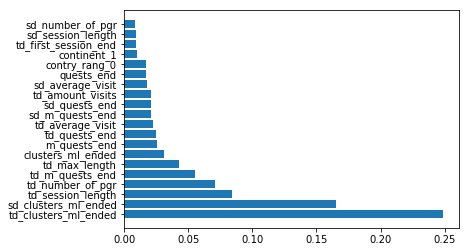

In [858]:
feature_importances_RFC = []
for name, importance in zip(fstd_ios.columns, RFC.feature_importances_):
    feature_importances_RFC.append([name, importance])
feature_importances_RFC.sort(key = lambda x: -x[1])
feature_importances_RFC = pd.DataFrame(feature_importances_RFC, columns = ['feature', 'importance'])
print('Важность признаков(RandomForestClassifier). Топ 20')
plt.figure()
plt.barh(range(20), feature_importances_RFC.importance[0:20])
plt.yticks(range(20), feature_importances_RFC.feature[0:20])
plt.show()

Настроим гиперпараметры на другой метрике качества

In [845]:
tree_params2 = {'max_depth': range(5,13), 'max_features': range(7, 27, 2), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}]}

In [846]:
tree_grid2 = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), tree_params2, cv=5, scoring='f1', verbose = True, n_jobs=-1)

In [847]:
tree_grid2.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 11.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 13), 'max_features': range(7, 27, 2), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=True)

In [848]:
tree_grid2.best_params_

{'class_weight': {0: 0.2, 1: 1}, 'max_depth': 7, 'max_features': 17}

In [850]:
DTC = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 1}, max_depth = 7, max_features = 17)
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.2, 1: 1}, max_depth = 7, max_features = 17')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.2, 1: 1}, max_depth = 7, max_features = 17
             precision    recall  f1-score   support

Не заплатит       0.97      0.93      0.95     40267
   Заплатит       0.35      0.57      0.43      2463

avg / total       0.94      0.91      0.92     42730

[[37622  1058]
 [ 2645  1405]]


In [859]:
RFC = RandomForestClassifier(n_estimators=100,  max_depth = 7, max_features = 17, class_weight = {0: 0.2, 1: 1})
RFC = RFC.fit(X_train, y_train)
print('RandomForestClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.2, 1: 1}, max_depth = 7, max_features = 17')
print(metrics.classification_report(y_test, RFC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, RFC.predict(X_test)).T)

RandomForestClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.2, 1: 1}, max_depth = 7, max_features = 17
             precision    recall  f1-score   support

Не заплатит       0.98      0.93      0.95     40267
   Заплатит       0.36      0.62      0.46      2463

avg / total       0.94      0.92      0.93     42730

[[37590   932]
 [ 2677  1531]]


Важность признаков(RandomForestClassifier). Топ 20


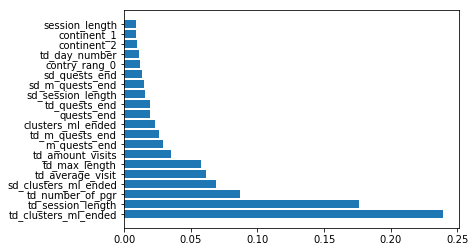

In [860]:
feature_importances_RFC = []
for name, importance in zip(fstd_ios.columns, RFC.feature_importances_):
    feature_importances_RFC.append([name, importance])
feature_importances_RFC.sort(key = lambda x: -x[1])
feature_importances_RFC = pd.DataFrame(feature_importances_RFC, columns = ['feature', 'importance'])
print('Важность признаков(RandomForestClassifier). Топ 20')
plt.figure()
plt.barh(range(20), feature_importances_RFC.importance[0:20])
plt.yticks(range(20), feature_importances_RFC.feature[0:20])
plt.show()

### Измерим LIFT

In [861]:
y_pred = RFC.predict(X_test) # порог 0.5
y_pred_proba = RFC.predict_proba(X_test)[:,1]
lift_df = pd.DataFrame({'probability': y_pred_proba, 'real_answer': y_test, 'answer': y_pred})
lift_df.sort_values('probability',ascending=False,inplace=True)
lift_df.head()

,answer,probability,real_answer
86460,1,0.981527,1
31182,1,0.981315,1
55819,1,0.981108,1
151090,1,0.981022,1
99914,1,0.980002,1


In [862]:
lift_table = [[0, 0, 0, 0, 0, 0, 0]]
positive = 0
random_variant = lift_df['real_answer'].sum()/10
rv_sum = 0
for i in range(10, 110, 10):
    cur_positive = lift_df['real_answer'][ int((i - 10) * lift_df.shape[0]/100 ) : int(i * lift_df.shape[0]/100)].sum()
    positive += cur_positive
    rv_sum += random_variant
    lift_table.append([i, cur_positive, positive, random_variant, rv_sum, round(cur_positive/2463, 3), round(random_variant/2463, 2)])
lift_table = pd.DataFrame(lift_table, columns = ['percent', 'prediction_answer', 'prediction_sum', 'random_answer',
                                                 'random_sum', 'pred_percent', 'random_percent'])

In [863]:
lift_table['sum_pred_percent'] = lift_table['pred_percent'].cumsum()*100
lift_table['sum_random_percent'] = lift_table['random_percent'].cumsum()*100

In [864]:
lift_table

,percent,prediction_answer,prediction_sum,random_answer,random_sum,pred_percent,random_percent,sum_pred_percent,sum_random_percent
0,0,0,0,0.0,0.0,0.000,0.0,0.0,0.0
1,10,1538,1538,246.3,246.3,0.624,0.1,62.4,10.0
2,20,540,2078,246.3,492.6,0.219,0.1,84.3,20.0
3,30,277,2355,246.3,738.9,0.112,0.1,95.5,30.0
4,40,95,2450,246.3,985.2,0.039,0.1,99.4,40.0
5,50,9,2459,246.3,1231.5,0.004,0.1,99.8,50.0
6,60,1,2460,246.3,1477.8,0.000,0.1,99.8,60.0
7,70,2,2462,246.3,1724.1,0.001,0.1,99.9,70.0
8,80,0,2462,246.3,1970.4,0.000,0.1,99.9,80.0
9,90,0,2462,246.3,2216.7,0.000,0.1,99.9,90.0


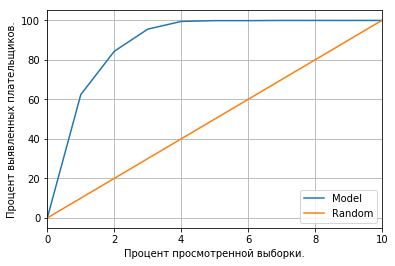

In [865]:
plt.figure()
lift_table['sum_pred_percent'].plot(label='Model')
lift_table['sum_random_percent'].plot(label='Random')
plt.ylabel('Процент выявленных плательщиков.')
plt.xlabel('Процент просмотренной выборки.')
plt.legend()
plt.grid(True)
plt.show()

Следовательно в первых 40 процентах ответах модели отранжированных по вероятности 99.4 процента от всех плательщиков.

## Добавим признаков

In [962]:
three_days_pact = pact_ios[(pact_ios['day_number'] == 2) | (pact_ios['day_number'] == 1) | (pact_ios['day_number'] == 3)]

In [963]:
three_days_pact.drop(['revenue', 'transactions', 'store_enters', 'day_number', 'crystals_value_spend'], axis = 1, inplace = True)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [958]:
fstd_ios = pd.read_csv('fstd_ios.csv')

In [959]:
fstd_ios.drop('Unnamed: 0', axis = 1, inplace = True)

In [960]:
fstd_ios['actdate'] = pd.to_datetime(fstd_ios['actdate'])
fstd_ios['sd_actdate'] = pd.to_datetime(fstd_ios['sd_actdate'])
fstd_ios['td_actdate'] = pd.to_datetime(fstd_ios['td_actdate'])

In [961]:
def day(date):
    if date.days < 0:
        return 0
    return date.days

fstd_ios['sd_delay'] = (fstd_ios['sd_actdate'] - fstd_ios['actdate']).apply(day)
fstd_ios['td_delay'] = (fstd_ios['td_actdate'] - fstd_ios['actdate']).apply(day)
fstd_ios['td_rel_sd_delay'] = (fstd_ios['td_actdate'] - fstd_ios['sd_actdate']).apply(day)

In [964]:
fstd_ios = pd.merge(fstd_ios, three_days_pact.groupby('id', as_index = False).sum()[['id', 'clusters_ml_ended','quests_end', 'm_quests_end']].rename(columns={'clusters_ml_ended': 'sum_clusters_ml_ended',
                                                           'quests_end': 'sum_quests_end',
                                                           'm_quests_end': 'sum_m_quests_end'
                                                          }), on=['id'], how='inner')

In [965]:
fstd_ios = pd.merge(fstd_ios, three_days_pact.groupby('id', as_index = False).max()[['id', 'clusters_ml_ended','quests_end', 'm_quests_end']].rename(columns={'clusters_ml_ended': 'max_clusters_ml_ended',
                                                           'quests_end': 'max_quests_end',
                                                           'm_quests_end': 'max_m_quests_end'
                                                          }), on=['id'], how='inner')

In [966]:
fstd_ios = pd.merge(fstd_ios, three_days_pact.groupby('id', as_index = False).min()[['id', 'clusters_ml_ended','quests_end', 'm_quests_end']].rename(columns={'clusters_ml_ended': 'min_clusters_ml_ended',
                                                           'quests_end': 'min_quests_end',
                                                           'm_quests_end': 'min_m_quests_end'
                                                          }), on=['id'], how='inner')

In [970]:
fstd_ios = pd.merge(fstd_ios, three_days_pact.groupby('id', as_index = False).mean()[['id', 'clusters_ml_ended','quests_end', 'm_quests_end']].rename(columns={'clusters_ml_ended': 'mean_clusters_ml_ended',
                                                           'quests_end': 'mean_quests_end',
                                                           'm_quests_end': 'mean_m_quests_end'
                                                          }), on=['id'], how='inner')

In [971]:
three_days_sessions = pd.merge(fstd_ios[['id', 'actdate']], sessions_ios, on=['id', 'actdate'], how='inner')

In [954]:
three_days_sessions.head()

,id,actdate,session_number,session_length,session_start_time,session_end_time
0,767bc9dfd3,2017-01-01,1.0,577,18:33:43,18:43:20
1,249241537d,2017-01-01,2.0,0,21:39:09,21:39:09
2,249241537d,2017-01-01,3.0,1145,21:54:45,22:13:50
3,249241537d,2017-01-01,4.0,1043,22:18:34,22:35:57
4,249241537d,2017-01-01,1.0,869,21:21:28,21:35:57


In [973]:
fstd_ios = pd.merge(fstd_ios, three_days_sessions.groupby('id', as_index = False).min()[['id', 'session_length']].rename(columns={'session_length': 'min_all_length'}), on=['id'], how='inner')
fstd_ios = pd.merge(fstd_ios, three_days_sessions.groupby('id', as_index = False).max()[['id', 'session_length']].rename(columns={'session_length': 'max_all_length'}), on=['id'], how='inner')

In [975]:
fstd_ios = pd.merge(fstd_ios, three_days_sessions.groupby('id', as_index = False).mean()[['id', 'session_length']].rename(columns={'session_length': 'mean_all_length'}), on=['id'], how='inner')


In [978]:
std_sess_all = three_days_sessions.groupby('id').std().rename(columns={'session_length': 'std_all_session_length'})['std_all_session_length']
std_sess_all = pd.DataFrame(std_sess_all)
std_sess_all.fillna(value = 0, inplace = True)
std_sess_all = std_sess_all.reset_index()
fstd_ios = pd.merge(fstd_ios, std_sess_all, on=['id'], how='inner')

In [980]:
fstd_ios.to_csv('new_fstd_ios.csv')

In [982]:
positive_id = pact_ios.groupby('id').sum()[pact_ios.groupby('id').sum()['revenue'] > 0].index
def cr_answer(id):
    return int(id in positive_id)

fstd_ios['answer'] = fstd_ios['id'].apply(cr_answer)
answer = fstd_ios['answer']

In [983]:
fstd_ios.drop(['id', 'answer', 'actdate', 'sd_actdate', 'td_actdate'], axis = 1, inplace = True)

In [986]:
#разделим выборку на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(fstd_ios, answer, test_size = 0.25, random_state = 42)

Обучим на данных по первым трем дням с новыми признаками.

In [987]:
DTC = DecisionTreeClassifier(class_weight = 'balanced')
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, обычные данные.')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, обычные данные.
             precision    recall  f1-score   support

Не заплатит       0.96      0.96      0.96     40267
   Заплатит       0.36      0.36      0.36      2463

avg / total       0.93      0.93      0.93     42730

[[38680  1587]
 [ 1587   876]]


Настроим гиперпараметры

In [988]:
tree_params = {'max_depth': range(4,13), 'max_features': range(6,22,2), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0:0.05, 1:1}]}

In [989]:
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring='f1_macro', verbose = True)

In [990]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 19.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(4, 13), 'max_features': range(6, 22, 2), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}, {0: 0.05, 1: 1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=True)

In [992]:
tree_grid.best_params_

{'class_weight': {0: 0.5, 1: 1}, 'max_depth': 8, 'max_features': 20}

In [997]:
DTC = DecisionTreeClassifier(class_weight = {0: 0.5, 1: 1}, max_depth = 8, max_features = 20)
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.5, 1: 1}, max_depth = 8, max_features = 20')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.5, 1: 1}, max_depth = 8, max_features = 20
             precision    recall  f1-score   support

Не заплатит       0.96      0.98      0.97     40267
   Заплатит       0.54      0.37      0.44      2463

avg / total       0.94      0.95      0.94     42730

[[39475  1549]
 [  792   914]]


In [998]:
RFC = RandomForestClassifier(n_estimators=100,  max_depth = 8, max_features = 20, class_weight = {0: 0.5, 1: 1})
RFC = RFC.fit(X_train, y_train)
print('RandomForestClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.5, 1: 1}, max_depth = 8, max_features = 20')
print(metrics.classification_report(y_test, RFC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, RFC.predict(X_test)).T)

RandomForestClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.5, 1: 1}, max_depth = 8, max_features = 20
             precision    recall  f1-score   support

Не заплатит       0.96      0.99      0.97     40267
   Заплатит       0.65      0.35      0.46      2463

avg / total       0.94      0.95      0.94     42730

[[39810  1601]
 [  457   862]]


In [999]:
tree_params2 = {'max_depth': range(5,13), 'max_features': range(7, 27, 2), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}]}

In [1000]:
tree_grid2 = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), tree_params2, cv=5, scoring='f1', verbose = True, n_jobs=-1)

In [1004]:
tree_grid2.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 11.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 13), 'max_features': range(7, 27, 2), 'class_weight': [{0: 0.5, 1: 1}, {0: 0.2, 1: 1}, {0: 0.1, 1: 1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=True)

In [1005]:
tree_grid2.best_params_

{'class_weight': {0: 0.2, 1: 1}, 'max_depth': 8, 'max_features': 17}

In [1006]:
DTC = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 1}, max_depth = 8, max_features = 17)
DTC.fit(X_train, y_train)
print('DecisionTreeClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.2, 1: 1}, max_depth = 8, max_features = 17')
print(metrics.classification_report(y_test, DTC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, DTC.predict(X_test)).T)

DecisionTreeClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.2, 1: 1}, max_depth = 8, max_features = 17
             precision    recall  f1-score   support

Не заплатит       0.97      0.93      0.95     40267
   Заплатит       0.35      0.61      0.44      2463

avg / total       0.94      0.91      0.92     42730

[[37418   961]
 [ 2849  1502]]


In [1007]:
RFC = RandomForestClassifier(n_estimators=100,  max_depth = 8, max_features = 17, class_weight = {0: 0.2, 1: 1})
RFC = RFC.fit(X_train, y_train)
print('RandomForestClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.2, 1: 1}, max_depth = 8, max_features = 17')
print(metrics.classification_report(y_test, RFC.predict(X_test), target_names = ['Не заплатит', 'Заплатит']))
print(metrics.confusion_matrix(y_test, RFC.predict(X_test)).T)

RandomForestClassifier, 3 первых дня, обычные данные. class_weight = {0: 0.2, 1: 1}, max_depth = 8, max_features = 17
             precision    recall  f1-score   support

Не заплатит       0.98      0.94      0.96     40267
   Заплатит       0.38      0.62      0.47      2463

avg / total       0.94      0.92      0.93     42730

[[37845   948]
 [ 2422  1515]]


Важность признаков(RandomForestClassifier). Топ 20


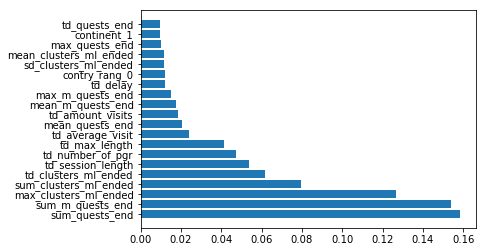

In [1008]:
feature_importances_RFC = []
for name, importance in zip(fstd_ios.columns, RFC.feature_importances_):
    feature_importances_RFC.append([name, importance])
feature_importances_RFC.sort(key = lambda x: -x[1])
feature_importances_RFC = pd.DataFrame(feature_importances_RFC, columns = ['feature', 'importance'])
print('Важность признаков(RandomForestClassifier). Топ 20')
plt.figure()
plt.barh(range(20), feature_importances_RFC.importance[0:20])
plt.yticks(range(20), feature_importances_RFC.feature[0:20])
plt.show()

In [1009]:
y_pred = RFC.predict(X_test) # порог 0.5
y_pred_proba = RFC.predict_proba(X_test)[:,1]
lift_df = pd.DataFrame({'probability': y_pred_proba, 'real_answer': y_test, 'answer': y_pred})
lift_df.sort_values('probability',ascending=False,inplace=True)
lift_df.head()

,answer,probability,real_answer
170794,1,0.993171,1
55819,1,0.993144,1
99914,1,0.993075,1
113448,1,0.992604,1
31182,1,0.992521,1


In [1010]:
lift_table = [[0, 0, 0, 0, 0, 0, 0]]
positive = 0
random_variant = lift_df['real_answer'].sum()/10
rv_sum = 0
for i in range(10, 110, 10):
    cur_positive = lift_df['real_answer'][ int((i - 10) * lift_df.shape[0]/100 ) : int(i * lift_df.shape[0]/100)].sum()
    positive += cur_positive
    rv_sum += random_variant
    lift_table.append([i, cur_positive, positive, random_variant, rv_sum, round(cur_positive/2463, 3), round(random_variant/2463, 2)])
lift_table = pd.DataFrame(lift_table, columns = ['percent', 'prediction_answer', 'prediction_sum', 'random_answer',
                                                 'random_sum', 'pred_percent', 'random_percent'])

In [1011]:
lift_table['sum_pred_percent'] = lift_table['pred_percent'].cumsum()*100
lift_table['sum_random_percent'] = lift_table['random_percent'].cumsum()*100

In [1012]:
lift_table

,percent,prediction_answer,prediction_sum,random_answer,random_sum,pred_percent,random_percent,sum_pred_percent,sum_random_percent
0,0,0,0,0.0,0.0,0.000,0.0,0.0,0.0
1,10,1572,1572,246.3,246.3,0.638,0.1,63.8,10.0
2,20,527,2099,246.3,492.6,0.214,0.1,85.2,20.0
3,30,273,2372,246.3,738.9,0.111,0.1,96.3,30.0
4,40,76,2448,246.3,985.2,0.031,0.1,99.4,40.0
5,50,12,2460,246.3,1231.5,0.005,0.1,99.9,50.0
6,60,1,2461,246.3,1477.8,0.000,0.1,99.9,60.0
7,70,0,2461,246.3,1724.1,0.000,0.1,99.9,70.0
8,80,2,2463,246.3,1970.4,0.001,0.1,100.0,80.0
9,90,0,2463,246.3,2216.7,0.000,0.1,100.0,90.0


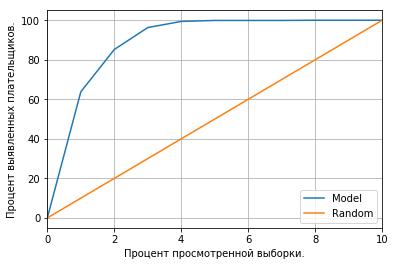

In [1013]:
plt.figure()
lift_table['sum_pred_percent'].plot(label='Model')
lift_table['sum_random_percent'].plot(label='Random')
plt.ylabel('Процент выявленных плательщиков.')
plt.xlabel('Процент просмотренной выборки.')
plt.legend()
plt.grid(True)
plt.show()